In [11]:
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.nets_and_embeddings import create_and_save_network_and_embedding
#from scripts.clustering_methods import clustering_method_values
from scripts.nets_and_embeddings import load_net_and_embedding
from scripts.nets_and_embeddings import create_embedding
import numpy as np

N=1000
mu_values = np.round(np.arange(0.05, 1.05, 0.05),decimals=2)

params = {
    "N": N,
    "k": 10,
    "maxk":  int(np.sqrt(10 * N)),
    "minc": 5,
    "maxc": int(np.ceil(np.sqrt(N * 10))),
    "tau": 3.0,
    "tau2": 1.0,
    "mu": 0.2,
    }


emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

run_no = 1
path_name= f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_{params['N']}_{params['k']}_3.0_immutable/Run_{run_no}/"
#path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_{params['N']}_{params['k']}_3.0_immutable/Run_{run_no}/"
#community_table_LFR_n_1000_tau1_3.0_tau2_1.0_mu_0.0_k_10_mincomm_5.npz
#"community_table_LFR_n_10000_tau1_3.0_tau2_1.0_mu_0.1_k_50_mincomm_50.npz"

net, community_table, emb = load_net_and_embedding(params, emb_params, path_name)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}
emb = create_embedding(net,emb_params,'node2vec')



# Calculate cosine similarity for all pairs
cosine_sim = cosine_similarity(emb)

# Get only the upper triangular part (excluding the diagonal)
upper_tri_sim = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]

# Calculate mean and standard deviation
mean_similarity = np.mean(upper_tri_sim)
std_similarity = np.std(upper_tri_sim)

print(min(upper_tri_sim)),print(max(upper_tri_sim))

-0.16317337344418895
0.972041054729678


(None, None)

In [5]:
print("Mean Cosine Similarity:", mean_similarity)
print("Standard Deviation of Cosine Similarity:", std_similarity)

NameError: name 'mean_similarity' is not defined

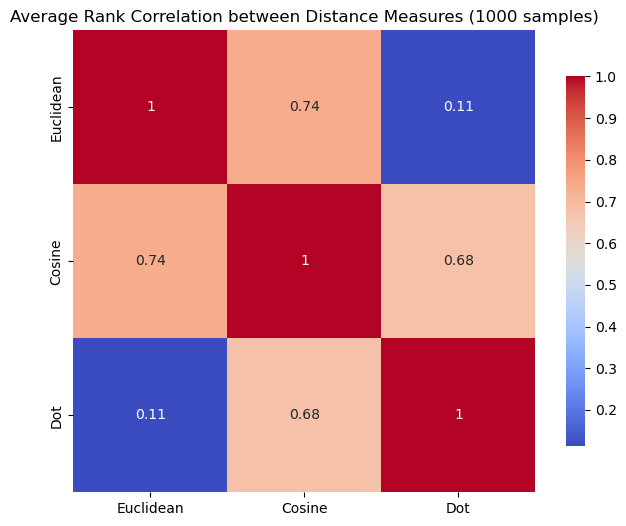

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_community_means(emb, community_ids):
    """
    Calculate the mean vector for each unique community.
    
    Parameters:
    - emb: Embedding array, shape (n_samples, n_features)
    - community_ids: Array of community IDs for each node, shape (n_samples,)
    
    Returns:
    - community_means: Array of mean vectors, shape (n_communities, n_features)
    """
    unique_communities = np.unique(community_ids)
    community_means = np.array([
        emb[community_ids == community].mean(axis=0) for community in unique_communities
    ])
    return community_means, unique_communities

def calculate_distances(random_vector, community_means):
    """
    Calculate Euclidean, Cosine, and Dot distances between a random vector and community mean vectors.
    
    Parameters:
    - random_vector: A single vector for distance comparison, shape (n_features,)
    - community_means: Array of mean vectors for each community, shape (n_communities, n_features)
    
    Returns:
    - distances: Dictionary with Euclidean, Cosine, and Dot similarity distances
    """
    euclidean_distances = cdist([random_vector], community_means, metric='euclidean').flatten()
    cosine_distances = cdist([random_vector], community_means, metric='cosine').flatten()
    dot_similarities = np.dot(community_means, random_vector)
    
    # For Dot similarity, we convert to a distance measure by taking the negative
    distances = {
        "Euclidean": euclidean_distances,
        "Cosine": cosine_distances,
        "Dot": -dot_similarities  # Negative dot similarity to treat as distance
    }
    return distances

def calculate_rank_correlation(distances):
    """
    Calculate Spearman rank correlation between different distance measures.
    
    Parameters:
    - distances: Dictionary with distance arrays for Euclidean, Cosine, and Dot similarity
    
    Returns:
    - rank_corr: Rank correlation matrix as a DataFrame for each distance type
    """
    dist_df = pd.DataFrame(distances)
    rank_corr = dist_df.corr(method='spearman')
    return rank_corr

# Main code
# Step 1: Calculate mean vector for each community
community_means, unique_communities = calculate_community_means(emb, community_table['community_id'])

# Step 2: Perform rank correlations for 1000 random points and accumulate results
rank_corr_sum = np.zeros((3, 3))  # Initialize a sum matrix for rank correlations

num_samples = 10000
for _ in range(num_samples):
    # Choose a random vector
    random_vector = emb[np.random.choice(emb.shape[0])]
    
    # Calculate distances from the random vector to each community mean
    distances = calculate_distances(random_vector, community_means)
    
    # Calculate rank correlation and add to the cumulative sum
    rank_corr = calculate_rank_correlation(distances).values  # Get correlation values as a numpy array
    rank_corr_sum += rank_corr

# Step 3: Average the rank correlations
average_rank_corr = rank_corr_sum / num_samples

# Convert to DataFrame for plotting
rank_corr_df = pd.DataFrame(average_rank_corr, index=["Euclidean", "Cosine", "Dot"], columns=["Euclidean", "Cosine", "Dot"])

# Step 4: Plot the average rank correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rank_corr_df, annot=True, cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Average Rank Correlation between Distance Measures (1000 samples)")
plt.show()

What about the pairwise distribution of distances?

In [2]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, squareform


def compute_node_distances(arr):
    """
    Computes the Euclidean distance, cosine similarity, and dot product similarity
    between all pairs of nodes, while avoiding redundant calculations.
    
    Parameters:
        arr (numpy.ndarray): Array of shape (2000, 64), where each row corresponds to a node.
    
    Returns:
        dict: A dictionary containing pairwise Euclidean distances, cosine similarities, and dot products.
    """

    # Euclidean distances (only unique pairs)
    euclidean_distances = pdist(arr, metric='euclidean')
    
    # Cosine similarities (only unique pairs)
    cosine_similarities = pdist(arr, metric='cosine')
    
    # Convert cosine distance to similarity (1 - cosine distance)
    cosine_similarities = 1 - cosine_similarities
    
    # Dot product similarities
    dot_similarities = pdist(arr, metric=lambda u, v: np.dot(u, v))
    
    return {
        'euclidean_distances': euclidean_distances,
        'cosine_similarities': cosine_similarities,
        'dot_similarities': dot_similarities
    }


import numpy as np

def condensed_index(i, j, n):
    """
    Convert the indices (i, j) from a squareform matrix to a condensed form index.
    The formula for converting squareform index to condensed index:
        k = n * i - i * (i + 1) // 2 + j - i - 1
    where i < j.

    Parameters:
        i (int): Row index.
        j (int): Column index.
        n (int): Number of nodes.

    Returns:
        int: Index in condensed matrix.
    """
    if i == j:
        raise ValueError("i and j should not be the same")
    if i > j:
        i, j = j, i
    return n * i - i * (i + 1) // 2 + (j - i - 1)

def filter_condensed_distances(community_labels, condensed_distances):
    """
    Filter the condensed distance vector to retain only the distances between nodes in the same community.
    
    Parameters:
        community_labels (np.array): Array of community labels for each node.
        condensed_distances (np.array): 1D condensed distance vector from pdist.
    
    Returns:
        np.array: Filtered condensed distance vector.
    """
    n = len(community_labels)
    filtered_distances = []

    # Loop through the upper triangular part of the matrix (i < j)
    for i in range(n):
        for j in range(i + 1, n):
            if community_labels[i] == community_labels[j]:
                # Get the corresponding condensed index
                condensed_idx = condensed_index(i, j, n)
                # Append the distance at this index to the filtered list
                filtered_distances.append(condensed_distances[condensed_idx])
    
    return np.array(filtered_distances)

In [3]:
distances = compute_node_distances(emb)

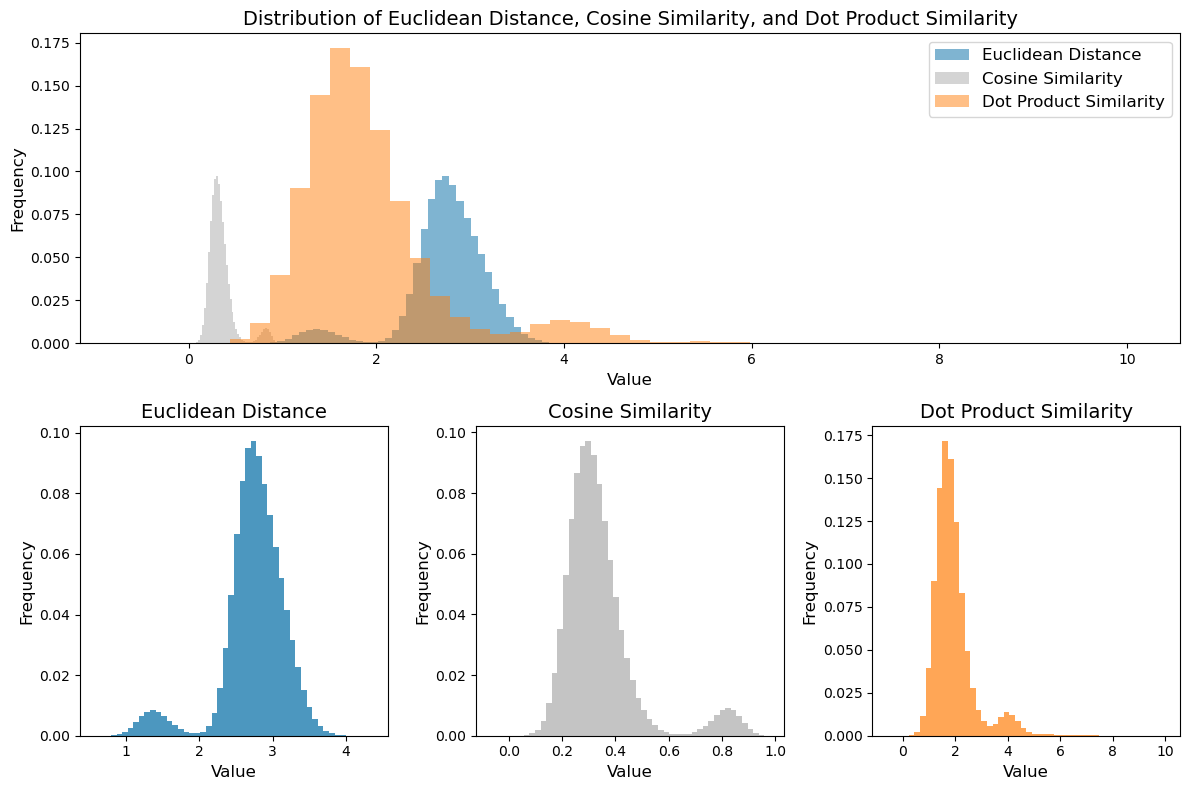

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Set the colorblind style
plt.style.use('tableau-colorblind10')
colorblind_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_distributions(euclidean, cosine, dot, title_fontsize=14, label_fontsize=12, tick_fontsize=10):
    """
    Plot distributions of Euclidean, Cosine, and Dot Product similarities with adjustable font sizes.
    
    Parameters:
    - euclidean, cosine, dot: Arrays of distance/similarity values for each metric.
    - title_fontsize: Font size for the titles of each plot.
    - label_fontsize: Font size for axis labels.
    - tick_fontsize: Font size for tick labels.
    """
    # Define consistent colors for each metric
    colors = {
        "Euclidean": colorblind_colors[0],  # First color in the colorblind palette
        "Cosine": colorblind_colors[2],     # Second color in the colorblind palette
        "Dot": colorblind_colors[1]         # Third color in the colorblind palette
    }
    
    fig = plt.figure(figsize=(12, 8))  # Define figure size to fit all plots in one
    
    # Create a grid layout with 2 rows and 3 columns
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1])  # Top row takes one column span

    # Combined plot (top row, spanning all columns)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.hist(euclidean, bins=50, alpha=0.5, label='Euclidean Distance', color=colors["Euclidean"], 
             weights=np.ones_like(euclidean) / len(euclidean))
    ax1.hist(cosine, bins=50, alpha=0.5, label='Cosine Similarity', color=colors["Cosine"], 
             weights=np.ones_like(cosine) / len(cosine))
    ax1.hist(dot, bins=50, alpha=0.5, label='Dot Product Similarity', color=colors["Dot"], 
             weights=np.ones_like(dot) / len(dot))
    ax1.legend(loc='upper right', fontsize=label_fontsize)
    ax1.set_title('Distribution of Euclidean Distance, Cosine Similarity, and Dot Product Similarity', fontsize=title_fontsize)
    ax1.set_xlabel('Value', fontsize=label_fontsize)
    ax1.set_ylabel('Frequency', fontsize=label_fontsize)
    ax1.tick_params(axis='both', labelsize=tick_fontsize)

    # Euclidean distance distribution (bottom row, first column)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(euclidean, bins=50, alpha=0.7, color=colors["Euclidean"], weights=np.ones_like(euclidean) / len(euclidean))
    ax2.set_title('Euclidean Distance', fontsize=title_fontsize)
    ax2.set_xlabel('Value', fontsize=label_fontsize)
    ax2.set_ylabel('Frequency', fontsize=label_fontsize)
    ax2.tick_params(axis='both', labelsize=tick_fontsize)

    # Cosine similarity distribution (bottom row, second column)
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(cosine, bins=50, alpha=0.7, color=colors["Cosine"], weights=np.ones_like(cosine) / len(cosine))
    ax3.set_title('Cosine Similarity', fontsize=title_fontsize)
    ax3.set_xlabel('Value', fontsize=label_fontsize)
    ax3.set_ylabel('Frequency', fontsize=label_fontsize)
    ax3.tick_params(axis='both', labelsize=tick_fontsize)

    # Dot product similarity distribution (bottom row, third column)
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(dot, bins=50, alpha=0.7, color=colors["Dot"], weights=np.ones_like(dot) / len(dot))
    ax4.set_title('Dot Product Similarity', fontsize=title_fontsize)
    ax4.set_xlabel('Value', fontsize=label_fontsize)
    ax4.set_ylabel('Frequency', fontsize=label_fontsize)
    ax4.tick_params(axis='both', labelsize=tick_fontsize)

    plt.tight_layout()
    plt.show()

# Example usage with adjustable font sizes
plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'],
                   title_fontsize=14, label_fontsize=14, tick_fontsize=10)


In [4]:
import numpy as np
from scipy.spatial.distance import squareform

def filter_all_condensed_distances_optimized(community_labels, euclidean_distances, cosine_distances, dot_distances):
    """
    Optimized filtering of the condensed distance vectors for all distance metrics (Euclidean, Cosine, Dot) 
    to retain distances between nodes within the same community and those between different communities.
    
    Parameters:
        community_labels (np.array): Array of community labels for each node.
        euclidean_distances (np.array): Condensed Euclidean distance vector from `pdist`.
        cosine_distances (np.array): Condensed Cosine similarity vector from `pdist`.
        dot_distances (np.array): Condensed Dot product similarity vector from `pdist`.
    
    Returns:
        dict: Dictionary containing in-community and out-community distances for each metric.
              Keys: 'euclidean_in', 'euclidean_out', 'cosine_in', 'cosine_out', 'dot_in', 'dot_out'
    """
    n = len(community_labels)
    community_labels = np.array(community_labels)

    # Convert condensed distances to square matrices for easier indexing
    euclidean_matrix = squareform(euclidean_distances)
    cosine_matrix = squareform(cosine_distances)
    dot_matrix = squareform(dot_distances)
    
    # Create a boolean matrix where True means nodes are in the same community
    same_community = np.equal.outer(community_labels, community_labels)
    upper_triangular = np.triu(np.ones((n, n), dtype=bool), k=1)  # Mask for upper triangle, without diagonal
    
    # Mask for in-community and out-community distances in the upper triangular matrix
    in_community_mask = same_community & upper_triangular
    out_community_mask = ~same_community & upper_triangular

    # Extract in-community and out-community distances using the masks
    results = {
        'euclidean_in': euclidean_matrix[in_community_mask],
        'euclidean_out': euclidean_matrix[out_community_mask],
        'cosine_in': cosine_matrix[in_community_mask],
        'cosine_out': cosine_matrix[out_community_mask],
        'dot_in': dot_matrix[in_community_mask],
        'dot_out': dot_matrix[out_community_mask]
    }
    
    return results

# Example usage
community_labels = community_table['community_id']  # Assuming this is a 1D array of community labels

# Get in/out community distances for all metrics
filtered_distances = filter_all_condensed_distances_optimized(
    community_labels,
    distances['euclidean_distances'],
    distances['cosine_similarities'],
    distances['dot_similarities']
)

# Access individual arrays if needed
euclidean_in = filtered_distances['euclidean_in']
euclidean_out = filtered_distances['euclidean_out']
cosine_in = filtered_distances['cosine_in']
cosine_out = filtered_distances['cosine_out']
dot_in = filtered_distances['dot_in']
dot_out = filtered_distances['dot_out']

In [3]:
net

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 500670 stored elements in Compressed Sparse Row format>

In [ ]:
# import pickle

# def save_distances(filename, distances, euclidean_in, euclidean_out, cosine_in, cosine_out, dot_in, dot_out):
#     """
#     Save distance arrays and filtered in/out community distances to a .pkl file using pickle.
    
#     Parameters:
#         filename (str): The filename for the .pkl file.
#         distances (dict): Dictionary with original condensed distances (e.g., Euclidean, Cosine, Dot).
#         euclidean_in, euclidean_out: Arrays of Euclidean distances within/outside the same community.
#         cosine_in, cosine_out: Arrays of Cosine similarities within/outside the same community.
#         dot_in, dot_out: Arrays of Dot product similarities within/outside the same community.
#     """
#     data_to_save = {
#         'distances': distances,
#         'euclidean_in': euclidean_in,
#         'euclidean_out': euclidean_out,
#         'cosine_in': cosine_in,
#         'cosine_out': cosine_out,
#         'dot_in': dot_in,
#         'dot_out': dot_out
#     }
    
#     with open(filename, 'wb') as f:
#         pickle.dump(data_to_save, f)

# # Example usage:
# save_distances("distances_data.pkl", distances, euclidean_in, euclidean_out, cosine_in, cosine_out, dot_in, dot_out)


# def load_distances(filename):
#     """
#     Load distance arrays and filtered in/out community distances from a .pkl file using pickle.
    
#     Parameters:
#         filename (str): The filename for the .pkl file.
    
#     Returns:
#         dict: A dictionary containing the loaded distances and filtered in/out community distances.
#     """
#     with open(filename, 'rb') as f:
#         data = pickle.load(f)
    
#     return data

# # Example usage:
# loaded_data = load_distances("distances_data.pkl")

# # Access data as needed
# distances = loaded_data['distances']
# euclidean_in = loaded_data['euclidean_in']
# euclidean_out = loaded_data['euclidean_out']
# cosine_in = loaded_data['cosine_in']
# cosine_out = loaded_data['cosine_out']
# dot_in = loaded_data['dot_in']
# dot_out = loaded_data['dot_out']

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

# Set the colorblind style and define custom colors
plt.style.use('tableau-colorblind10')
colorblind_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Custom colors for each metric
colors = {
    "Euclidean": colorblind_colors[0],  # First color for Euclidean
    "Cosine": colorblind_colors[2],     # Second color for Cosine
    "Dot": colorblind_colors[1]         # Third color for Dot
}

def calculate_overlap(distribution_in, distribution_out, bins=50):
    """
    Calculate the overlap coefficient between two distributions.
    
    Parameters:
    - distribution_in: Array of values for in-community distances.
    - distribution_out: Array of values for out-community distances.
    - bins: Number of bins to use for histogram calculation.
    
    Returns:
    - overlap: The overlap coefficient between the two distributions.
    """
    # Calculate histograms for both distributions
    hist_in, bin_edges = np.histogram(distribution_in, bins=bins, density=True)
    hist_out, _ = np.histogram(distribution_out, bins=bin_edges, density=True)
    
    # Calculate the overlap by summing the minimum values of each bin
    overlap = np.sum(np.minimum(hist_in, hist_out) * np.diff(bin_edges))
    return overlap

def plot_distributions_by_community(euclidean_in, euclidean_out, 
                                    cosine_in, cosine_out, 
                                    dot_in, dot_out, 
                                    title_fontsize=14, label_fontsize=12, tick_fontsize=10):
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1.5])

    # Calculate combined weights for normalization across both distributions
    total_len_euclidean = len(euclidean_in) + len(euclidean_out)
    total_len_cosine = len(cosine_in) + len(cosine_out)
    total_len_dot = len(dot_in) + len(dot_out)

    
    euclidean_combined = np.concatenate((euclidean_in, euclidean_out))
    cosine_combined = np.concatenate((cosine_in, cosine_out))
    dot_combined = np.concatenate((dot_in, dot_out))
    
    # # Set weights for normalization
    # euclidean_weights = np.ones_like(euclidean_combined) / len(euclidean_combined)
    # cosine_weights = np.ones_like(cosine_combined) / len(cosine_combined)
    # dot_weights = np.ones_like(dot_combined) / len(dot_combined)

    # Set normalized weights
    euclidean_weights_in = np.ones_like(euclidean_in) / total_len_euclidean
    euclidean_weights_out = np.ones_like(euclidean_out) / total_len_euclidean
    cosine_weights_in = np.ones_like(cosine_in) / total_len_cosine
    cosine_weights_out = np.ones_like(cosine_out) / total_len_cosine
    dot_weights_in = np.ones_like(dot_in) / total_len_dot
    dot_weights_out = np.ones_like(dot_out) / total_len_dot

    # Combined plot (top row, spanning all columns)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot each histogram with weights
    ax1.hist(euclidean_combined, bins=50, alpha=0.5, color=colors["Euclidean"], label='Euclidean', density=True)
    ax1.hist(cosine_combined, bins=50, alpha=0.5, color=colors["Cosine"], label='Cosine', density=True)
    ax1.hist(dot_combined, bins=50, alpha=0.5, color=colors["Dot"], label='Dot', density=True)


    ax1.legend(loc='upper right', fontsize=label_fontsize)
    ax1.set_title('Density Distribution of Pairwise Distances', fontsize=title_fontsize)
    ax1.set_xlabel('Value', fontsize=label_fontsize)
    ax1.set_ylabel('Density', fontsize=label_fontsize)
    ax1.tick_params(axis='both', labelsize=tick_fontsize)
    ax1.set_xlim([-0.1,6])

    # Separate plots for each distance type with different opacities and hatching
    # Calculate overlaps and display on bottom row plots
    euclidean_overlap = calculate_overlap(euclidean_in, euclidean_out)
    cosine_overlap = calculate_overlap(cosine_in, cosine_out)
    dot_overlap = calculate_overlap(dot_in, dot_out)

    # Euclidean distance distribution
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(euclidean_in, bins=50, alpha=0.8, color=colors["Euclidean"], label='In-Community', weights=euclidean_weights_in)
    ax2.hist(euclidean_out, bins=50, alpha=0.3, color=colors["Euclidean"], label='Out-Community', weights=euclidean_weights_out, hatch='//')
    ax2.set_title('Euclidean Distance', fontsize=title_fontsize)
    ax2.set_xlabel('Value', fontsize=label_fontsize)
    ax2.set_ylabel('Frequency', fontsize=label_fontsize)
    ax2.tick_params(axis='both', labelsize=tick_fontsize)
    ax2.text(0.95, 0.95, f'Overlap: {euclidean_overlap:.2f}', ha='right', va='top', transform=ax2.transAxes, fontsize=label_fontsize, color='black')

    # Cosine similarity distribution
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(cosine_in, bins=50, alpha=0.8, color=colors["Cosine"], label='In-Community', weights=cosine_weights_in)
    ax3.hist(cosine_out, bins=50, alpha=0.3, color=colors["Cosine"], label='Out-Community', weights=cosine_weights_out, hatch='//')
    ax3.set_title('Cosine Similarity', fontsize=title_fontsize)
    ax3.set_xlabel('Value', fontsize=label_fontsize)
    ax3.set_ylabel('Frequency', fontsize=label_fontsize)
    ax3.tick_params(axis='both', labelsize=tick_fontsize)
    ax3.text(0.95, 0.95, f'Overlap: {cosine_overlap:.2f}', ha='right', va='top', transform=ax3.transAxes, fontsize=label_fontsize, color='black')

    # Dot product similarity distribution
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(dot_in, bins=50, alpha=0.8, color=colors["Dot"], label='In-Community', weights=dot_weights_in)
    ax4.hist(dot_out, bins=50, alpha=0.3, color=colors["Dot"], label='Out-Community', weights=dot_weights_out, hatch='//')
    ax4.set_title('Dot Product Similarity', fontsize=title_fontsize)
    ax4.set_xlabel('Value', fontsize=label_fontsize)
    ax4.set_ylabel('Frequency', fontsize=label_fontsize)
    ax4.tick_params(axis='both', labelsize=tick_fontsize)
    ax4.text(0.95, 0.95, f'Overlap: {dot_overlap:.2f}', ha='right', va='top', transform=ax4.transAxes, fontsize=label_fontsize, color='black')

    # Adjust layout to make space for a centered legend below the plots
    fig.subplots_adjust(bottom=0.4)  # Add space at the bottom for the legend

    # Create a custom legend for In-Community and Out-Community
    custom_legend = [
        Patch(facecolor='black', alpha=0.8, label='Within Community pairs'),
        Patch(facecolor='black', alpha=0.3, hatch='//', label='Between Community pairs')
    ]
    fig.legend(handles=custom_legend, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=label_fontsize)

    plt.tight_layout()
    plt.savefig("/nobackup/gogandhi/alt_means_sans_k/results/Changing clustering metric/pairwise_dist_dist_edges_mixed.png", dpi = 300, bbox_inches='tight')

    plt.show()

# Example usage
#plot_distributions_by_community(euclidean_in, euclidean_out, cosine_in, cosine_out, dot_in, dot_out, title_fontsize=16, label_fontsize=16, tick_fontsize=16)


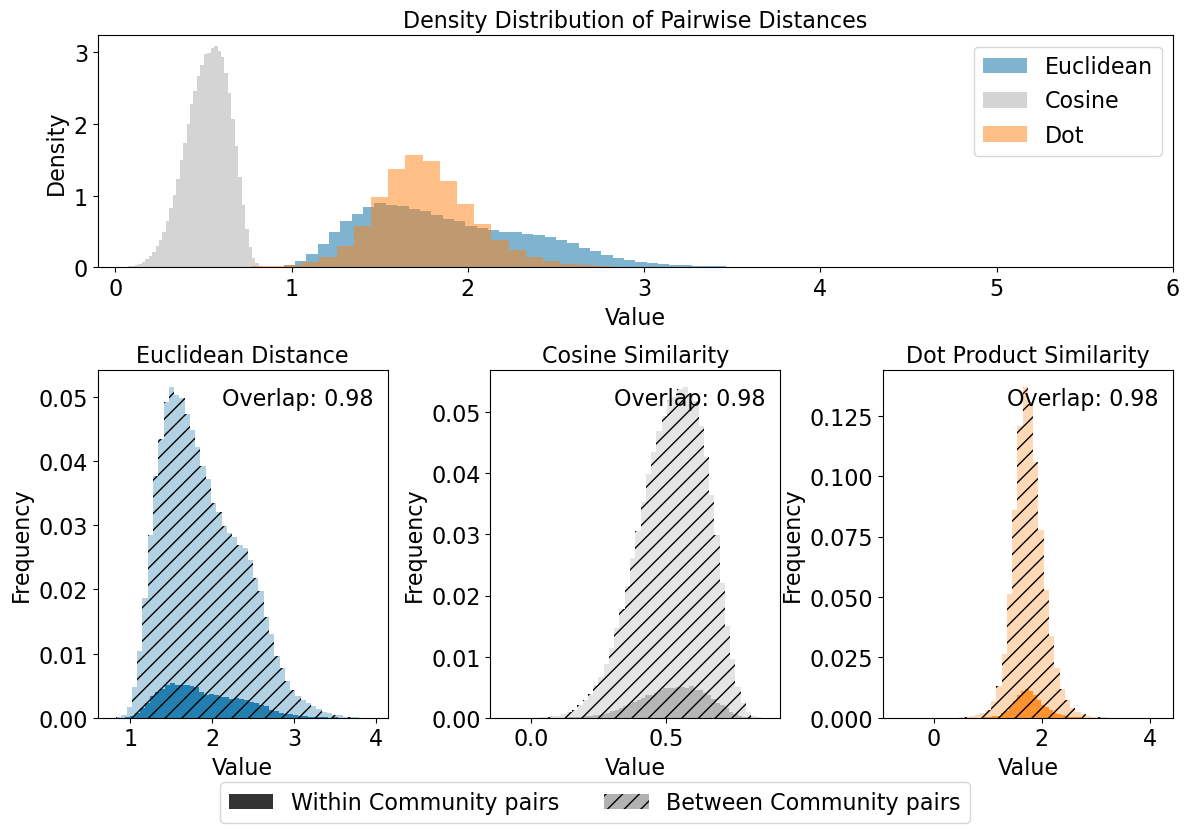

In [12]:
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

def compute_edge_distances_with_community_labels(emb, net, community_labels):
    """
    Calculate distances between connected nodes, categorized by in-community and out-community pairs.

    Parameters:
    - emb (numpy.ndarray): Node embeddings with shape (N, dim).
    - net (scipy.sparse.csr_matrix): Sparse adjacency matrix of the network.
    - community_labels (numpy.ndarray): Array of community labels for each node.

    Returns:
    - dict: Dictionary containing in-community and out-community distances for Euclidean, Cosine, and Dot product.
    """
    n = emb.shape[0]
    within_community = {
        'euclidean': [],
        'cosine': [],
        'dot': []
    }
    between_community = {
        'euclidean': [],
        'cosine': [],
        'dot': []
    }
    
    # Iterate over the edges only
    row_indices, col_indices = net.nonzero()
    for i, j in zip(row_indices, col_indices):
        if i >= j:
            continue  # Avoid double counting (upper triangular part only)

        # Calculate distances
        euclidean_dist = np.linalg.norm(emb[i] - emb[j])
        cosine_sim = 1 - cosine(emb[i], emb[j])
        dot_sim = np.dot(emb[i], emb[j])

        # Check if they are in the same community or different communities
        if community_labels[i] == community_labels[j]:
            within_community['euclidean'].append(euclidean_dist)
            within_community['cosine'].append(cosine_sim)
            within_community['dot'].append(dot_sim)
        else:
            between_community['euclidean'].append(euclidean_dist)
            between_community['cosine'].append(cosine_sim)
            between_community['dot'].append(dot_sim)

    return {
        'within_community': within_community,
        'between_community': between_community
    }

# Example usage
distances = compute_edge_distances_with_community_labels(emb, net, community_table['community_id'])

# Access distances for plotting
euclidean_in = distances['within_community']['euclidean']
euclidean_out = distances['between_community']['euclidean']
cosine_in = distances['within_community']['cosine']
cosine_out = distances['between_community']['cosine']
dot_in = distances['within_community']['dot']
dot_out = distances['between_community']['dot']

# Plot using the provided plotting function
plot_distributions_by_community(euclidean_in, euclidean_out, cosine_in, cosine_out, dot_in, dot_out, 
                                title_fontsize=16, label_fontsize=16, tick_fontsize=16)

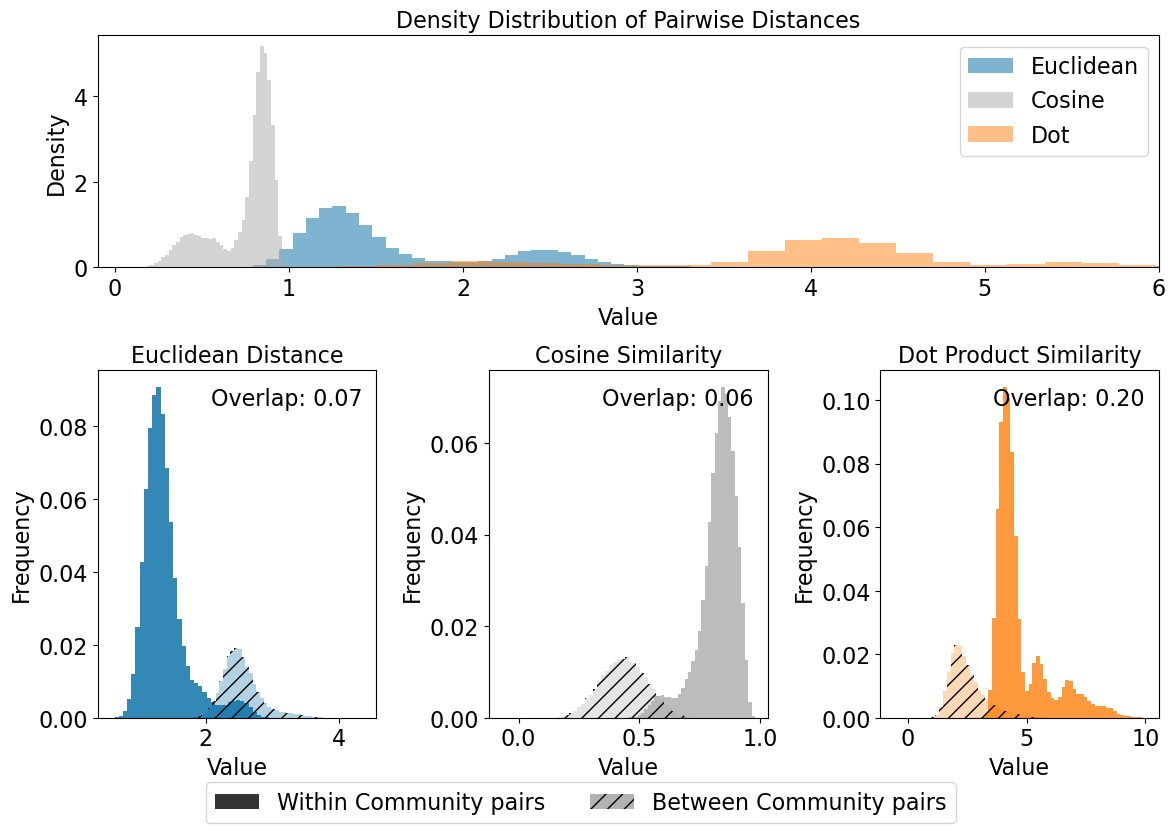